In [1]:
import networkx as nx
import math
G=nx.Graph()

n=0
V=[]
with open("vert_coord.txt",'r',encoding='utf-8') as f:
	for line in f:
		if n==0:
			n=int(line)
			continue
		[x,y]=line.split(' ')
		V.append((len(V),{"x":int(x),"y":int(y)}))

def ed(u,v):
	x=V[u][1]['x']-V[v][1]['x']
	y=V[u][1]['y']-V[v][1]['y']
	return (u,v,math.sqrt(x*x+y*y))

m=0
E=[]
with open("edge_conn.txt",'r',encoding='utf-8') as ff:
	for line in ff:
		if m==0:
			m=int(line)
			continue
		[u,v]=line.split(' ')
		if u=="0" and v=="0\n":
			break
		E.append(ed(int(u),int(v)))
m=len(E)

G.add_nodes_from(V)
G.add_weighted_edges_from(E)
nx.write_gml(G,"map.gml")

In [2]:
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import poisson, expon
from tqdm import tqdm
import random

%matplotlib inline
graph=nx.read_gml("map.gml")

In [3]:
# number of nodes and edges
n, m = graph.number_of_nodes(), graph.number_of_edges()
print(f"Num nodes: {n}, Num edges: {m}")

# connected components
connected_components = nx.connected_components(graph)
subgraphs = [graph.subgraph(c) for c in connected_components]
print(f"Num connected components: {len(subgraphs)}")
for subgraph in subgraphs:
	num_nodes = subgraph.number_of_nodes()
	print(f"Num nodes in component: {num_nodes}")

Num nodes: 171, Num edges: 277
Num connected components: 2
Num nodes in component: 170
Num nodes in component: 1


In [4]:
# mean degree
mean_degree = np.mean(list(dict(graph.degree()).values()))
mean_degree_square = np.mean([degree**2 for degree in dict(graph.degree()).values()])
print(f"Mean degree: {mean_degree}, Mean degree squared: {mean_degree_square}")

# max degree
max_degree = max(dict(graph.degree()).values())
print(f"Max degree: {max_degree}")

Mean degree: 3.239766081871345, Mean degree squared: 11.216374269005849
Max degree: 5


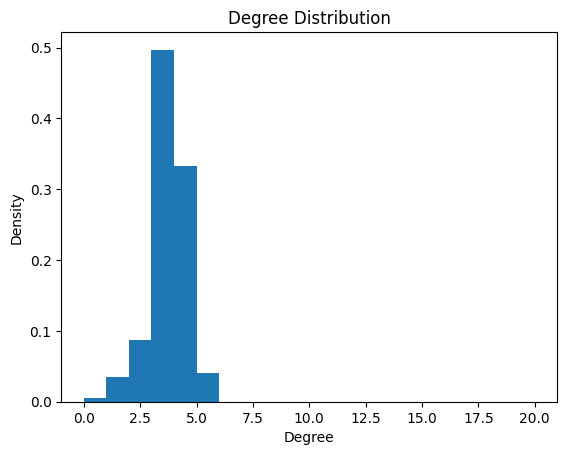

In [5]:
# degree distribution
def degree_distribution_plot(graph):
	degrees = [graph.degree(node) for node in graph.nodes()]
	plt.hist(degrees, bins=np.arange(0, 21), density=True)
	plt.xlabel("Degree")
	plt.ylabel("Density")
	plt.title("Degree Distribution")
	plt.show()

degree_distribution_plot(graph)

p in ER graph: 0.019057447540419676


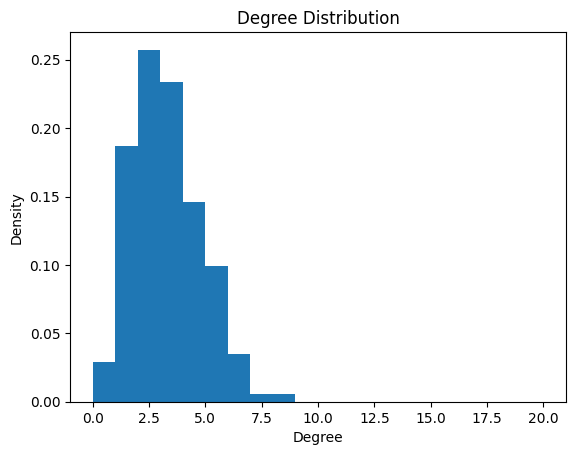

In [6]:
# compare with Erdos-Renyi Graph
p = mean_degree / (n-1)
print(f"p in ER graph: {p}")

ER_graph = nx.erdos_renyi_graph(n, p)
degree_distribution_plot(ER_graph)

# 结论  
## 连通分支：  
有两个，但实际上该孤立点(点#166)为绘图时方便操作留下的，没有特殊意义；  
故网络实际上就是连通的，而多出的孤立点只影响后续计算的正规化因子，不妨碍结论。  
## 度分布  
平均度为3.240，均方为11.216，可知方差相当小，进一步意味着大度数点存在率极低；  
作图可见三度点占比接近50%，而ER图中仅26%；  
ER图中次多的四度点占23%，而在网络中该比例仍有32%之高；  
其他度数在网络中的出现则远远少于ER图，如二度点为9%对18%，五度点为4%对14%；  
网络中不再有大于等于6的点，这也从根本上否决了其构成小世界图的可能性。

In [7]:
# clustering coefficient
clustering_coef = nx.average_clustering(graph)
print(f"Clustering coefficient: {clustering_coef}")

Clustering coefficient: 0.0354775828460039


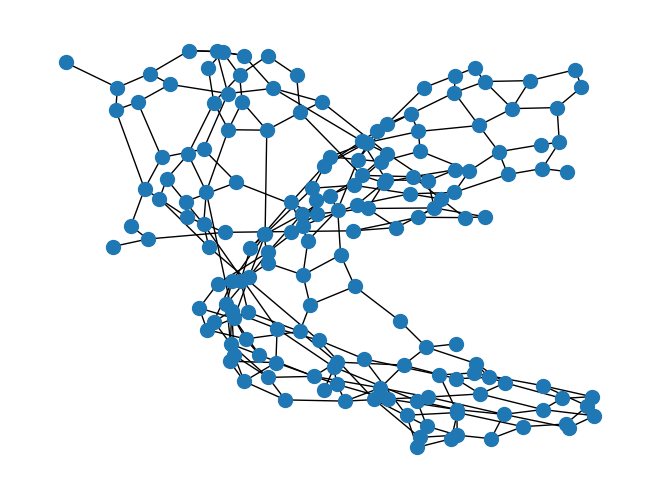

In [8]:
# plot the component
large_subgraph = max(subgraphs, key=lambda x: x.number_of_nodes())
pos = nx.spring_layout(large_subgraph, iterations=100)
nx.draw(large_subgraph, pos, with_labels=False, node_size=100, font_size=8)
plt.show()

In [58]:
# verify a graph of map is ofcoursely planar
nx.is_planar(graph)

True

## 聚类系数  
聚类系数仅有0.0355，即三角形几乎不存在，这是由于三角形地块若规划建筑则利用率较低，故而土地规划时就避免了三角形的存在；  
本网络中的极个例比有49-51-52围出的南区15号楼，以及127-128-129-130所代表的六教的中穿结构；  
非建筑则有73-74-72的绿地、33-37-40的球场和107-120-121区域（22-23-30、102-114-168和155-158-163为小块空地，24-26-28、47-48-49为简化得到的结构）。  
## 结构  
绘制结果并无美丽的性质，但该网络当然是平面图，因为它本身就是由真实二维地图得到的。

In [46]:
def get_centrality(graph):
	centrality_dict = {}
	centrality_dict['degree'] = nx.degree_centrality(graph)
	centrality_dict['betweenness'] = nx.betweenness_centrality(graph, k=100, weight='weight')
	centrality_dict['closeness'] = nx.closeness_centrality(graph, distance='weight')
	centrality_dict['pagerank'] = nx.pagerank(graph)
	return centrality_dict

centrality_dict = get_centrality(graph)

# get nodes with highest centrality score
def get_top_k_nodes(centrality_dict, k):
	top_k_nodes = {}
	for key in centrality_dict:
		top_k_nodes[key] = sorted(centrality_dict[key].items(), key=lambda x: x[1], reverse=True)[:k]
	return top_k_nodes

top_k_nodes = get_top_k_nodes(centrality_dict, k=5)
for key in centrality_dict:
	print(f"Measure: {key}")
	for node in top_k_nodes[key]:
		print(node)

Measure: degree
('11', 0.029411764705882353)
('17', 0.029411764705882353)
('25', 0.029411764705882353)
('29', 0.029411764705882353)
('49', 0.029411764705882353)
Measure: betweenness
('116', 0.1655241907413853)
('107', 0.15623912286808214)
('48', 0.15320361990950226)
('52', 0.14046641141663765)
('126', 0.1361214758092586)
Measure: closeness
('116', 0.001410262971882166)
('52', 0.0013999493068573064)
('125', 0.0013902329230511144)
('64', 0.001379596935592973)
('59', 0.0013709604404098712)
Measure: pagerank
('41', 0.010499413310298317)
('17', 0.010100844587213904)
('100', 0.00931994627974328)
('154', 0.008968546348712931)
('94', 0.008964556478768732)


In [56]:
# SSSP from my dormitory
source = '71'
shortest_path = nx.single_source_dijkstra_path_length(large_subgraph, source=source, weight='weight')
print(shortest_path)

{'71': 0, '75': 77.05841939723393, '69': 121.92620719107111, '70': 133.00375934536586, '29': 149.129148208542, '76': 178.8916163420417, '68': 182.01396236473724, '28': 197.13956374517323, '73': 200.8502212805737, '25': 205.20878937422364, '77': 208.2453089860949, '60': 219.62028240285042, '27': 244.38669384142088, '20': 280.20878937422367, '24': 283.74787743387174, '63': 293.71481661422126, '26': 296.54278300893753, '79': 308.95314024515454, '19': 327.2194264683963, '67': 328.0037593453659, '61': 330.4099465118471, '109': 330.44596364882574, '74': 342.13716335237314, '72': 359.00204706832744, '23': 362.2653914036861, '50': 367.03127249517695, '66': 374.6942294650809, '62': 379.6391126511064, '18': 380.2288595911906, '64': 382.08883982955786, '12': 400.01220726742525, '51': 406.00016739516684, '110': 413.2046489936281, '80': 421.17167703832433, '16': 427.23949668536324, '30': 439.36921750849103, '52': 464.186342836653, '44': 466.4246515992015, '65': 474.6631194908807, '22': 482.68133719

In [50]:
# average distance between nodes
num_nodes = 171
node_samples = large_subgraph.nodes()
sum_shortest_path_lengths = sum(l for u in node_samples for l in nx.single_source_dijkstra_path_length(large_subgraph, u, weight='weight').values())
average_distance = sum_shortest_path_lengths / (num_nodes * (large_subgraph.number_of_nodes()-1))
average_distance

976.4724314973719

In [53]:
# longest distance between nodes
longest_distance = max(l for u in node_samples for l in nx.single_source_dijkstra_path_length(large_subgraph, u, weight='weight').values())
longest_distance

2745.0529433936385

In [54]:
nx.diameter(large_subgraph, weight='weight')

2745.0529433936385

## 中心性  
度中心性意义并不大，因为网络中最大度仅为并列的若干五度点；  
中介中心性与距离中心性一致地指向了点#116(即学堂路上文科图书馆与清芬园之间的路口)作为地图的中心，这与其作为事故率最高路口的情况完全吻合；  
而中介中心性排名次席的路口却是点#107(即新水利馆东北方、五教背后小路与河岸的路口)，这是由于其拥有两条斜边而位于不少“近路”之上（第三名点#48也是如此）；  
相比之下距离中心性第二、第三位的点#52和点#125则均为#116的邻点，不难理解这是平面地图生成网络所带来的性质；  
页面排序并不具有实际意义，点#17出现是因为度数较大，而其他则是因为与校门相邻，相当于额外拥有一个完整入邻居的权重。

## 最短路径  
平均最短路径长度为976米，最长距离为2745米(亦即图的直径)；  
从本人宿舍(点#71南21)出发前往各校门(#163东南门、#164南门、#113西门、#85西北门、#42东北门、#138东三门)分别需1876米、1752米、1664米、770米、1215米、1614米。

In [59]:
# robustness: randomly remove nodes and see how the size of the largest connected component changes
def random_node_deletion_experiment(G, num_iterations=10, end=150, step=1):
	results = []
	for i in tqdm(range(1, end, step)):
		max_connected_components = []
		for _ in range(num_iterations):
			H = G.copy()
			nodes_to_remove = random.sample(H.nodes(), i)
			H.remove_nodes_from(nodes_to_remove)
			connected_components = list(nx.connected_components(H))
			if connected_components:
				max_connected_components.append(max(map(len, connected_components)))
			else:
				max_connected_components.append(0)
		average_max_connected_component = sum(max_connected_components) / num_iterations
		results.append(average_max_connected_component)
	return results

  0%|                                                                                          | 0/169 [00:00<?, ?it/s]C:\Users\theorygd\AppData\Local\Temp\ipykernel_23336\3796028714.py:8: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  nodes_to_remove = random.sample(H.nodes(), i)
100%|███████████████████████████████████████████████████████████████████████████████| 169/169 [00:01<00:00, 166.81it/s]


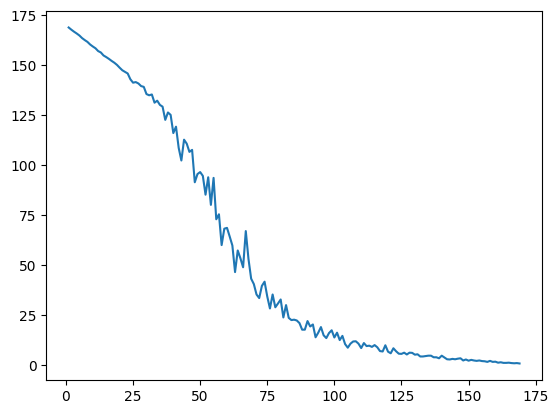

In [63]:
result = random_node_deletion_experiment(graph, num_iterations=10, end=170, step=1)
x = np.arange(1, 170, 1)
plt.plot(x, result)

100%|█████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 15832.87it/s]


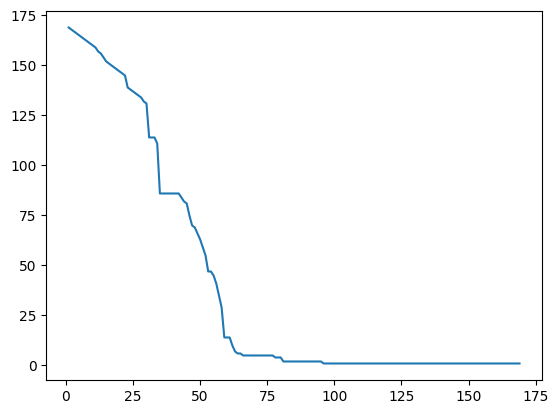

In [64]:
def attack_sequential_deletion_experiment(graph, end=150, step=1):
    # delete nodes with highest degree sequentially
    results = []
    graph = graph.copy()
    for _ in tqdm(range(1, end, step)):
        nodes_to_remove = sorted(graph.nodes(), key=graph.degree, reverse=True)[:step]
        graph.remove_nodes_from(nodes_to_remove)
        connected_components = list(nx.connected_components(graph))
        results.append(max(map(len, connected_components)))
    return results

result = attack_sequential_deletion_experiment(graph, end=170, step=1)
x = np.arange(1, 170, 1)
plt.plot(x, result)

## 鲁棒性  
分别以纯随机和最高度点的策略逐个瘫痪网络里的点，绘制得到二图像；  
两种情况在前20个点差别不大，但之后下降较快，不过并未显现出在针对性攻击下的薄弱；  
这似乎也是横平竖直的地图转化出网络所拥有的特性之一。

# PS  
## 数据收集  
本网络的源数据使用了较为原始的方法收集，即：  
1. 从[https://www.earthol.com/g/](https://www.earthol.com/g/)中下载校园的卫星地图，共8×10张256×256像素地图（文件夹1、2内）；
2. 用ps拼接为2048×2560的大图thumap.jpg，并标记所有作为网络中点的路口（有部分取舍和简化）；
3. 记录所有点在图片中的坐标，得到vert_coord.txt文件，并导出图片为thmap_vert.jpg；
4. 编写gra_gen.cpp程序，将手动记录的点与边文件转换为graph_out.svg矢量图，并以真实图片衬底；
5. 对照矢量图中所应当存在的边，逐个加入edge_conn.txt文件，直到得到完整的网络。
## 数据处理  
将文本文档转化为.gml文件存储，其中还包括计算每条边两端点的L2距离作为边权。